# Pyaudio Microphone Streaming Examples

A simple notebook that uses pyaudio to get the microphone audio and feeds this audio then to Silero VAD.

I created it as an example on how binary data from a stream could be feed into Silero VAD.


Has been tested on Ubuntu 21.04 (x86). After you installed the dependencies below, no additional setup is required.

This notebook does not work in google colab! For local usage only.

## Dependencies
The cell below lists all used dependencies and the used versions. Uncomment to install them from within the notebook.

In [2]:
#!pip install numpy>=1.24.0
#!pip install torch>=1.12.0
# !pip install matplotlib>=3.6.0
#!pip install torchaudio>=0.12.0
#!pip install soundfile==0.12.1
#!apt install python3-pyaudio (linux) or pip install pyaudio (windows)


## Imports

In [1]:
import io
import numpy as np
import torch
torch.set_num_threads(1)
import torchaudio
import matplotlib
import matplotlib.pylab as plt
import pyaudio

In [2]:
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /home/shamila/.cache/torch/hub/master.zip


In [4]:
(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

### Helper Methods

In [5]:
# Taken from utils_vad.py
def validate(model,
             inputs: torch.Tensor):
    with torch.no_grad():
        outs = model(inputs)
    return outs

# Provided by Alexander Veysov
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound

## Pyaudio Set-up

In [6]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
SAMPLE_RATE = 16000
CHUNK = int(SAMPLE_RATE / 10)

audio = pyaudio.PyAudio()

ALSA lib pcm_dsnoop.c:567:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1000:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_dmix.c:1000:(snd_pcm_dmix_open) unable to open slave


## Simple Example
The following example reads the audio as 250ms chunks from the microphone, converts them to a Pytorch Tensor, and gets the probabilities/confidences if the model thinks the frame is voiced.

In [7]:
num_samples = 512

Started Recording
Stopped the recording


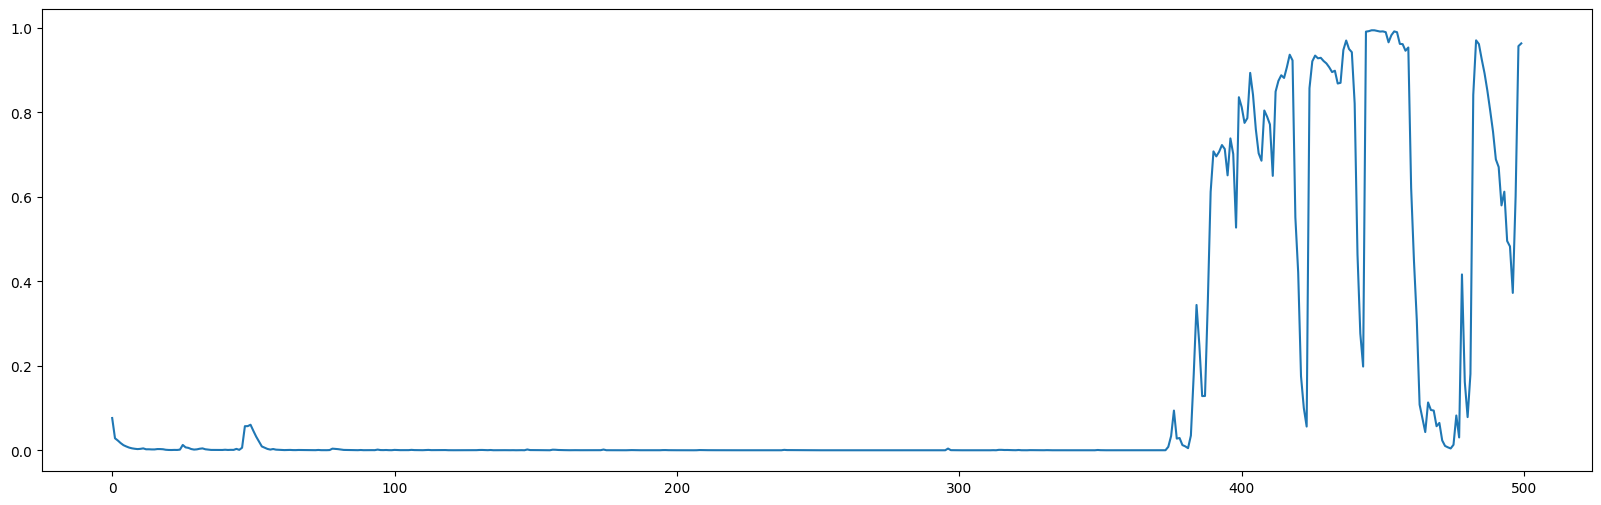

In [8]:
stream = audio.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=SAMPLE_RATE,
                    input=True,
                    frames_per_buffer=CHUNK)
data = []
voiced_confidences = []

frames_to_record = 500

print("Started Recording")
for i in range(0, frames_to_record):
    
    audio_chunk = stream.read(num_samples)
    
    # in case you want to save the audio later
    data.append(audio_chunk)
    
    audio_int16 = np.frombuffer(audio_chunk, np.int16);

    audio_float32 = int2float(audio_int16)
    
    # get the confidences and add them to the list to plot them later
    new_confidence = model(torch.from_numpy(audio_float32), 16000).item()
    voiced_confidences.append(new_confidence)
    
print("Stopped the recording")

# plot the confidences for the speech
plt.figure(figsize=(20,6))
plt.plot(voiced_confidences)
plt.show()

## Real Time Visualization

As an enhancement to plot the speech probabilities in real time I added the implementation below.
In contrast to the simeple one, it records the audio until to stop the recording by pressing enter.
While looking into good ways to update matplotlib plots in real-time, I found a simple libarary that does the job. https://github.com/lvwerra/jupyterplot It has some limitations, but works for this use case really well.


In [15]:
!pip install jupyterplot==0.0.3

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'lrcurve' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lrcurve'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for lrcurve: filename=lrcurve-1.1.0-py3-none-any.whl size=69183 sha256=4f4c48de1f6fb48da2fb0a4ded0548b7b7943639045135c7cc42c9a09a5d60a4
  Stored in directory: /home/shamila/.cache/pip/wheels/db/3b/df/2b8b6f4b333df04960460f43842d59bfcf455afa6c01fcc2e8
Successfully built lrcurve
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [jupyterplot]


In [17]:
from jupyterplot import ProgressPlot
import threading

continue_recording = True

def stop():
    input("Press Enter to stop the recording:")
    global continue_recording
    continue_recording = False

def start_recording():
    
    stream = audio.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=SAMPLE_RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    data = []
    voiced_confidences = []
    
    global continue_recording
    continue_recording = True
    
    pp = ProgressPlot(plot_names=["Silero VAD"],line_names=["speech probabilities"], x_label="audio chunks")
    
    stop_listener = threading.Thread(target=stop)
    stop_listener.start()

    while continue_recording:
    
        audio_chunk = stream.read(num_samples)
    
        # in case you want to save the audio later
        data.append(audio_chunk)
    
        audio_int16 = np.frombuffer(audio_chunk, np.int16);

        audio_float32 = int2float(audio_int16)
    
        # get the confidences and add them to the list to plot them later
        new_confidence = model(torch.from_numpy(audio_float32), 16000).item()
        voiced_confidences.append(new_confidence)
    
        pp.update(new_confidence)


    pp.finalize()

In [18]:
start_recording()

In [10]:
import whisper

model = whisper.load_model("tiny")
# result = model.transcribe("audio.wav", word_timestamps=True)
result = model.transcribe("06_At_the_Doctors_English_Conversation_YouTube.wav", word_timestamps=True)

print(result["text"])

/home/shamila/anaconda3/envs/whisper/lib/python3.10/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_loca

 Good morning. What seems to be the problem? Well, I've been having really bad pains near my chest area. I've been struggling to get any sleep or go to work because of the pain. I'm going to press on your stomach. Tell me where I hurts. Yes, that's where it hurts most. Okay, so it seems that you have abdominal pain. What's that? Abdomen refers to your stomach. So you have stomach pains. How long have you had this pain fall? About a week now. Are you having any problems with your bowel movement? Sorry. What do you mean by that? Are you able to go to the toilet without any problems? No. I'm actually really struggling to go to the toilet. It's very painful. Okay. So it seems that you have a common type of bowel problem. This is called constipation. This is usually caused by lack of fibre intake, exercise or not drinking enough liquids. Ah. To be honest, I rarely drink water or exercise. So that's the problem. I recommend that you make some changes to your diet and lifestyle. Drink at leas

In [11]:
print([result])

[{'text': " Good morning. What seems to be the problem? Well, I've been having really bad pains near my chest area. I've been struggling to get any sleep or go to work because of the pain. I'm going to press on your stomach. Tell me where I hurts. Yes, that's where it hurts most. Okay, so it seems that you have abdominal pain. What's that? Abdomen refers to your stomach. So you have stomach pains. How long have you had this pain fall? About a week now. Are you having any problems with your bowel movement? Sorry. What do you mean by that? Are you able to go to the toilet without any problems? No. I'm actually really struggling to go to the toilet. It's very painful. Okay. So it seems that you have a common type of bowel problem. This is called constipation. This is usually caused by lack of fibre intake, exercise or not drinking enough liquids. Ah. To be honest, I rarely drink water or exercise. So that's the problem. I recommend that you make some changes to your diet and lifestyle. Dr

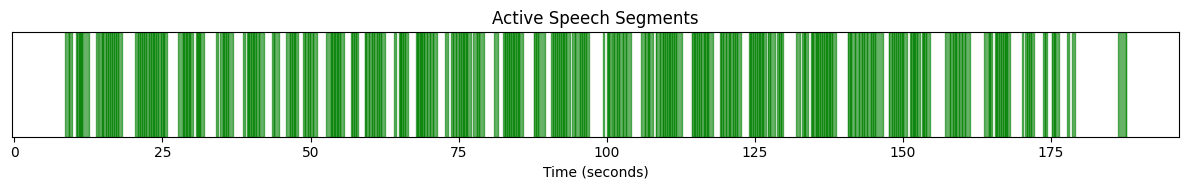

In [12]:
import matplotlib.pyplot as plt

# Extract all word intervals
speech_segments = []
for segment in result['segments']:
    for word_info in segment['words']:
        start = float(word_info['start'])
        end = float(word_info['end'])
        speech_segments.append((start, end))

# Plot
plt.figure(figsize=(12, 2))
for start, end in speech_segments:
    plt.axvspan(start, end, color='green', alpha=0.6)  # highlight speech region

# Optional: configure timeline
plt.title("Active Speech Segments")
plt.xlabel("Time (seconds)")
plt.yticks([])  # No y-axis
plt.tight_layout()
plt.show()


[{'start': 9.0, 'end': 9.8}, {'start': 10.3, 'end': 11.8}, {'start': 13.6, 'end': 14.0}, {'start': 14.5, 'end': 18.1}, {'start': 20.6, 'end': 24.3}, {'start': 24.5, 'end': 25.7}, {'start': 28.1, 'end': 30.0}, {'start': 30.6, 'end': 31.9}, {'start': 33.8, 'end': 34.5}, {'start': 34.8, 'end': 36.8}, {'start': 38.4, 'end': 39.0}, {'start': 39.2, 'end': 41.8}, {'start': 43.4, 'end': 44.5}, {'start': 45.7, 'end': 48.0}, {'start': 48.6, 'end': 49.2}, {'start': 49.3, 'end': 51.0}, {'start': 53.1, 'end': 55.3}, {'start': 56.6, 'end': 58.0}, {'start': 59.1, 'end': 62.5}, {'start': 64.0, 'end': 64.6}, {'start': 64.8, 'end': 66.4}, {'start': 67.8, 'end': 71.2}, {'start': 72.6, 'end': 73.3}, {'start': 73.7, 'end': 77.2}, {'start': 77.6, 'end': 79.4}, {'start': 81.3, 'end': 81.9}, {'start': 82.4, 'end': 85.8}, {'start': 87.5, 'end': 89.5}, {'start': 90.7, 'end': 93.8}, {'start': 94.0, 'end': 94.9}, {'start': 95.2, 'end': 97.2}, {'start': 99.0, 'end': 99.5}, {'start': 100.0, 'end': 104.3}, {'start':

/tmp/ipykernel_68047/1053798313.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


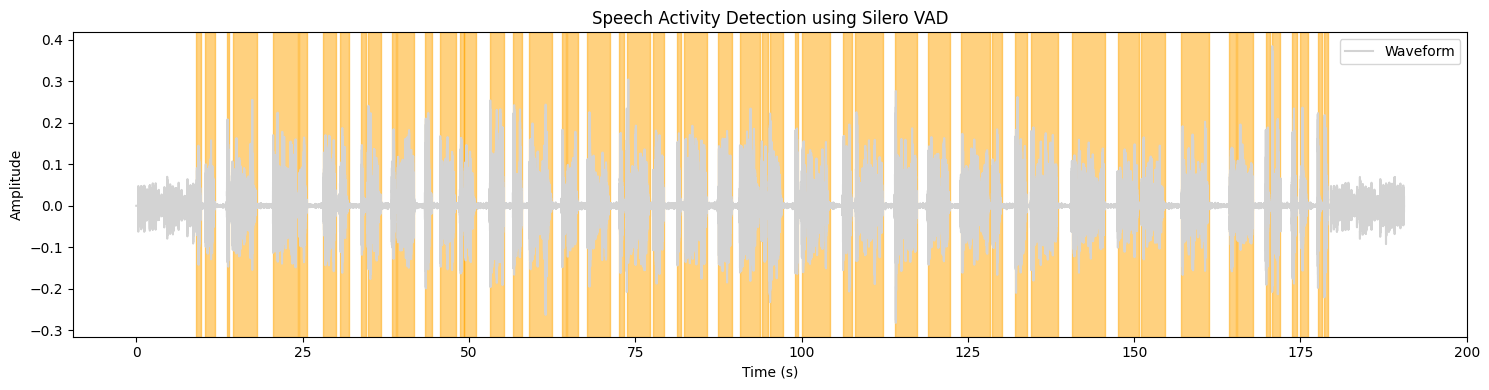

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from silero_vad import load_silero_vad, read_audio, get_speech_timestamps

# Load the Silero VAD model
model = load_silero_vad()

# Read the audio file 
wav = read_audio('06_At_the_Doctors_English_Conversation_YouTube.wav')

# Get speech timestamps in seconds
speech_timestamps = get_speech_timestamps(wav, model, return_seconds=True)
print(speech_timestamps)

# Plot waveform with speech regions
sr = 16000  # Sampling rate used by Silero VAD
time = np.arange(len(wav)) / sr

plt.figure(figsize=(15, 4))
plt.plot(time, wav, label="Waveform", color='lightgray')

# Highlight speech regions
for ts in speech_timestamps:
    plt.axvspan(ts['start'], ts['end'], color='orange', alpha=0.5)

plt.title("Speech Activity Detection using Silero VAD")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
!pip install soundfile

  Using cached soundfile-0.13.1-py2.py3-none-manylinux_2_28_x86_64.whl.metadata (16 kB)
  Using cached cffi-1.17.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
Using cached soundfile-0.13.1-py2.py3-none-manylinux_2_28_x86_64.whl (1.3 MB)
Using cached cffi-1.17.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (446 kB)
Using cached pycparser-2.22-py3-none-any.whl (117 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [soundfile]/3 [soundfile]


In [ ]:
import os
import soundfile as sf
from silero_vad import load_silero_vad, read_audio, get_speech_timestamps

# Load model
model = load_silero_vad()

# Read audio (returns a 1D torch.Tensor)
wav = read_audio('06_At_the_Doctors_English_Conversation_YouTube.wav')
sr = 16000  # Silero uses 16kHz

# Get speech timestamps
speech_timestamps = get_speech_timestamps(wav, model, return_seconds=False)

# Create output directory
output_dir = "speech_chunks"
os.makedirs(output_dir, exist_ok=True)

# Save each chunk
for i, ts in enumerate(speech_timestamps):
    chunk = wav[ts['start']:ts['end']]
    out_path = os.path.join(output_dir, f"chunk_{i+1:03d}.wav")
    sf.write(out_path, chunk.numpy(), sr)
    print(f"Saved: {out_path}")


Saved: speech_chunks/chunk_001.wav
Saved: speech_chunks/chunk_002.wav
